In [1]:
# Import modules we'll need for this notebook
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import logging

logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)

import mlflow
import mlflow.sklearn



In [2]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join('../scripts')))


In [3]:
mlflow.set_experiment('forcast')

<Experiment: artifact_location='file:///C:/Users/ende/Desktop/test/notebooks/mlruns/1', experiment_id='1', lifecycle_stage='active', name='forcast', tags={}>

In [4]:
mlflow.start_run()

<ActiveRun: >

In [5]:
#loading the dataset
df = pd.read_csv('C:/Users/ende/Desktop/test/data/final.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1058297 entries, 0 to 1058296
Data columns (total 14 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   Store                1058297 non-null  int64  
 1   DayOfWeek            1058297 non-null  int64  
 2   Date                 1058297 non-null  object 
 3   Open                 1058297 non-null  int64  
 4   Promo                1058297 non-null  int64  
 5   StateHoliday         1058297 non-null  object 
 6   SchoolHoliday        1058297 non-null  int64  
 7   Sales                1058297 non-null  float64
 8   Customers            1058297 non-null  float64
 9   StoreType            1058297 non-null  object 
 10  Assortment           1058297 non-null  object 
 11  CompetitionDistance  1058297 non-null  float64
 12  Promo2               1058297 non-null  int64  
 13  compdate             1058297 non-null  object 
dtypes: float64(3), int64(6), object(5)
memory usage: 9

In [6]:
df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'Sales', 'Customers', 'StoreType', 'Assortment',
       'CompetitionDistance', 'Promo2', 'compdate'],
      dtype='object')

In [8]:
mlflow.log_artifact(r'C:\Users\ende\Desktop\test\data\final.csv')

In [9]:
df.SchoolHoliday.unique()

array([0, 1], dtype=int64)

In [11]:

df['day'] = pd.DatetimeIndex(df['Date']).day
df['compdate'] = pd.DatetimeIndex(df['compdate']).day
numeric_features = ['Store', 'DayOfWeek','Customers','CompetitionDistance']
categorical_features = ['Open','Assortment','StoreType','Promo2','Promo','StateHoliday', 'SchoolHoliday']
df[numeric_features + ['Sales']].describe()
print(df.head())




   Store  DayOfWeek        Date  Open  Promo StateHoliday  SchoolHoliday  \
0      1          4  2015-09-17     1      1            0              0   
1      1          3  2015-09-16     1      1            0              0   
2      1          2  2015-09-15     1      1            0              0   
3      1          1  2015-09-14     1      1            0              0   
4      1          7  2015-09-13     0      0            0              0   

    Sales  Customers StoreType Assortment  CompetitionDistance  Promo2  \
0  5263.0      555.0         c          a               1270.0       0   
1  5263.0      555.0         c          a               1270.0       0   
2  5263.0      555.0         c          a               1270.0       0   
3  5263.0      555.0         c          a               1270.0       0   
4  5263.0      555.0         c          a               1270.0       0   

   compdate  day  
0         1   17  
1         1   16  
2         1   15  
3         1   14  
4  

In [12]:
# change categorical variables to numerical value
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
df['Assortment'] = lb.fit_transform(df['Assortment'])
df['StateHoliday'] = lb.fit_transform(df['StateHoliday'])
df['SchoolHoliday'] = lb.fit_transform(df['SchoolHoliday'])
df['StoreType'] = lb.fit_transform(df['StoreType'])
df['Promo2'] = lb.fit_transform(df['Promo2'])
df['Promo'] = lb.fit_transform(df['Promo'])
df['Open'] = lb.fit_transform(df['Open'])





In [13]:
# Separate features and labels
# After separating the dataset, we now have numpy arrays named **X** containing the features, and **y** containing the labels.
X, y = df[['Store', 'DayOfWeek','Customers','CompetitionDistance','Open','Assortment','StoreType','Promo2','Promo','StateHoliday', 'SchoolHoliday']].values, df['Sales'].values
# Split data 70%-30% into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

print ('Training Set: %d rows\nTest Set: %d rows' % (X_train.shape[0], X_test.shape[0]))

Training Set: 740807 rows
Test Set: 317490 rows


In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, r2_score
from sklearn.ensemble import GradientBoostingRegressor
# Use a Gradient Boosting algorithm
alg = GradientBoostingRegressor()

# Try these hyperparameter values
params = {
 'learning_rate': [0.1, 0.5, 1.0],
 'n_estimators' : [50, 100, 150]
 }




In [15]:
# Find the best hyperparameter combination to optimize the R2 metric
score = make_scorer(r2_score)
gridsearch = GridSearchCV(alg, params, scoring=score, cv=3, return_train_score=True)

In [16]:
gridsearch.fit(X_train[0:5000], y_train[0:5000])
print("Best parameter combination:", gridsearch.best_params_, "\n")


Best parameter combination: {'learning_rate': 0.5, 'n_estimators': 150} 



In [17]:
# Get the best model
model=gridsearch.best_estimator_
print(model, "\n")

GradientBoostingRegressor(learning_rate=0.5, n_estimators=150) 



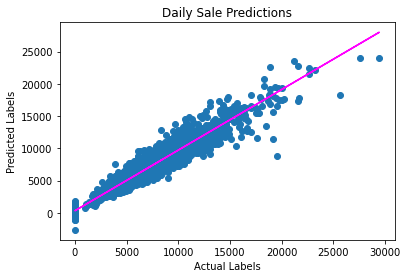

In [18]:
# Get predictions
predictions = model.predict(X_test[0:5000])
# Plot predicted vs actual
plt.scatter(y_test[0:5000], predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Daily Sale Predictions')
z = np.polyfit(y_test[0:5000], predictions, 1)
p = np.poly1d(z)
plt.plot(y_test[0:5000],p(y_test[0:5000]), color='magenta')
plt.show()
# overlay the regression line


In [19]:
# Train the model
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
import numpy as np

# Define preprocessing for numeric columns (scale them)
numeric_features = [7,8,9,10]
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# Define preprocessing for categorical features (encode them)
categorical_features = [0,1,2,3,4,5,6]
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])



In [20]:
# Create preprocessing and training pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', GradientBoostingRegressor())])


# fit the pipeline to train a linear regression model on the training set
model = pipeline.fit(X_train[0:5000], y_train[0:5000])
print (model)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [7, 8, 9, 10]),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [0, 1, 2, 3, 4, 5, 6])])),
                ('regressor', GradientBoostingRegressor())])


In [21]:
# Get predictions
predictions = model.predict(X_test[0:5000])

# Display metrics
mse = mean_squared_error(y_test[0:5000], predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test[0:5000], predictions)
print("R2:", r2)



MSE: 5115292.443463582
RMSE: 2261.7012277185468
R2: 0.6371512151299643


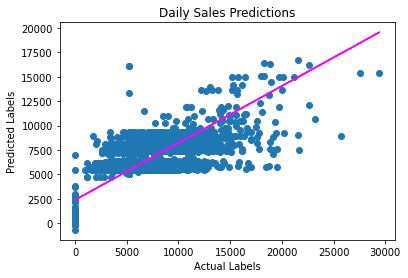

In [22]:
# Plot predicted vs actual
plt.scatter(y_test[0:5000], predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Daily Sales Predictions')
z = np.polyfit(y_test[0:5000], predictions, 1)
p = np.poly1d(z)
plt.plot(y_test[0:5000],p(y_test[0:5000]), color='magenta')
plt.show()

In [23]:
# Use a different estimator in the pipeline
from sklearn.ensemble import RandomForestRegressor
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', RandomForestRegressor())])


# fit the pipeline to train a linear regression model on the training set
model = pipeline.fit(X_train[0:5000], (y_train[0:5000]))
print (model, "\n")

# Get predictions
predictions = model.predict(X_test[0:5000])





Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [7, 8, 9, 10]),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [0, 1, 2, 3, 4, 5, 6])])),
                ('regressor', RandomForestRegressor())]) 



In [26]:
# Display metrics
mse = mean_squared_error(y_test[0:5000], predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test[0:5000], predictions)
print("R2:", r2)

MSE: 4284254.340635353
RMSE: 2069.844037756312
R2: 0.6961001743780788


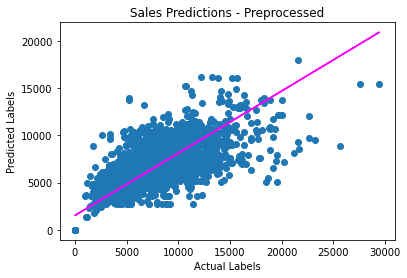

In [27]:
# Plot predicted vs actual
plt.scatter(y_test[0:5000], predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Sales Predictions - Preprocessed')
z = np.polyfit(y_test[0:5000], predictions, 1)
p = np.poly1d(z)
plt.plot(y_test[0:5000],p(y_test[0:5000]), color='magenta')
plt.show()

#### Based on the R2 score RandomForestRegressor is the best model.

In [28]:
mlflow.sklearn.log_model(model, "model")

c:\Users\ende\AppData\Local\Programs\Python\Python38-32\lib\site-packages\_distutils_hack\__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


ModelInfo(artifact_path='model', flavors={'python_function': {'model_path': 'model.pkl', 'loader_module': 'mlflow.sklearn', 'python_version': '3.8.3', 'env': 'conda.yaml'}, 'sklearn': {'pickled_model': 'model.pkl', 'sklearn_version': '1.0.2', 'serialization_format': 'cloudpickle', 'code': None}}, model_uri='runs:/7a177d189b774a88a9adb1031c6c3a0e/model', model_uuid='a5b4d940810e42ce959298da2aa5b312', run_id='7a177d189b774a88a9adb1031c6c3a0e', saved_input_example_info=None, signature_dict=None, utc_time_created='2022-05-29 12:25:52.003992', mlflow_version='1.26.0')

In [29]:
import joblib

# Save the model as a pickle file
filename = './salesforcast.pkl'
joblib.dump(model, filename)

['./salesforcast.pkl']

In [31]:
# Load the model from the file
loaded_model = joblib.load(filename)

# Create a numpy array containing a new observation 
X_new = np.array([[1,6,1,0,0,1,555,3,1,1270,0]])
print ('New sample: {}'.format(list(X_new[0])))

# Use the model to predict tomorrow's rentals
result = loaded_model.predict(X_new)
print('Prediction: {:.0f} sales'.format(np.round(result[0])))

New sample: [1, 6, 1, 0, 0, 1, 555, 3, 1, 1270, 0]
Prediction: 6245 sales


In [32]:
mlflow.end_run()